In [1]:
import sys
sys.path.append("../src")
from dataio import *
from metric import *
import datetime
import pandas as pd
from matplotlib import pyplot as plt
import geopandas as gpd

In [3]:
dams = load_dam_details()


### 1. Daily Evaluation

##### 1.1 全体なエラー

- Use the different metrics you have and present them in one clear plot
- Compare with linear model

In [4]:
dam_id,ms,ns,kg = [],[],[],[]
num = []

for idx in dams.index:
    #load data
    rivout = load_dam_rivout(idx,daily=True)
    rivout = rivout[rivout.index>=datetime.datetime(2018,9,1)]
    discharge = load_dam_discharge(idx)
    
    if len(discharge)==0:
        print(f"no discharge data at {idx}")
        continue
    discharge = pd.concat(load_dam_discharge(idx))
    
    #match timezone
    discharge.index -= datetime.timedelta(hours=9)
    
    #use data after 2018/9/1 to to match hourly data
    discharge = discharge[discharge.index >= datetime.datetime(2018,9,1)]
    
    #transform discharge to daily data 
    discharge.index = discharge.index.date
    discharge.index.name = 'date'
    discharge = discharge.groupby(level=['date']).mean()
    discharge.index = pd.to_datetime(discharge.index)
    
    #calculate the data at the time when both rivout and discharge exist
    rivout = rivout[rivout.index.isin(discharge.index)]
    discharge = discharge[discharge.index.isin(rivout.index)]
       
    
    if len(discharge)==0:
        print(f"no matching date at {idx}")
        continue
        
    dam_id.append(idx)
    num.append(len(discharge))
    ms.append(mse(rivout.values,discharge.values))
    ns.append(nse(rivout.values,discharge.values))
    kg.append(kge(rivout.values,discharge.values))

no discharge data at 1368010325190
no matching date at 1368020475240


/home/yoshimi/Hydro/hydro_exp/../src/metric.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - mse(output,observed)/np.var(observed)
/home/yoshimi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/yoshimi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/yoshimi/Hydro/hydro_exp/../src/metric.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  a = np.std(output)/np.std(observed)
/home/yoshimi/Hydro/hydro_exp/../src/metric.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  b = np.mean(output)/np.mean(observed)


no discharge data at 1368080364020
no matching date at 602111282217030


#### problem 
there may be the data discharge is zero at the all calculating time ,so zero deviding is occured when calc variance.
I don't know what to do, so I ignore this data for now

In [75]:
err_table = pd.DataFrame({"id":dam_id,"mse":ms,"ns":ns,"kge":kg,}).set_index("id")
err_table = err_table.drop(index=1368050751020)

In [13]:
err_table.mean(axis=0)

/tmp/ipykernel_15271/3585593851.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  err_table.mean(axis=0)


mse    8.254581e+06
ns    -1.905544e+01
kge   -7.061813e-01
dtype: float64

<AxesSubplot:xlabel='ns', ylabel='kge'>

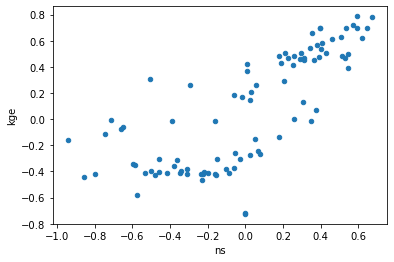

In [ ]:
err_table[err_table["ns"]>-1].plot.scatter(x="ns",y="kge")

### check most fittin sample

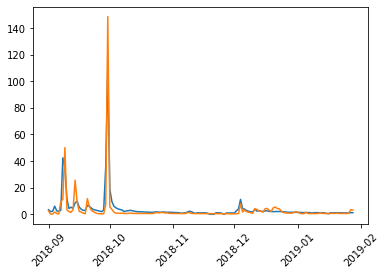

In [84]:
idx = err_table["ns"].idxmax()
rivout = load_dam_rivout(idx,daily=True)
rivout = rivout[rivout.index>=datetime.datetime(2018,9,1)]
discharge = load_dam_discharge(idx)
discharge = pd.concat(load_dam_discharge(idx))
discharge.index -= datetime.timedelta(hours=9)
discharge.index = discharge.index.date
discharge.index.name = 'date'
discharge = discharge.groupby(level=['date']).mean()
discharge.index = pd.to_datetime(discharge.index)
discharge = discharge[discharge.index >= datetime.datetime(2018,9,1)]
rivout = rivout[rivout.index.isin(discharge.index)]
discharge = discharge[discharge.index.isin(rivout.index)]

plt.plot(discharge[:150])
plt.plot(rivout[:150])
plt.xticks(rotation=45)
plt.show()

##### 1.２ ダムごとの分析

- ダムごとのエラーの分布
- うまく行ってるダムの共有点ありますか？　（ダムのサイズ、県など）
- うまく行ってないダムの共有点ありますか？

### 2. Hourly Evaluation